In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

# used to make it easy to generate trajectories
def trajectory_1D(l):
    ll = []
    for s in l:
        ll.append(paths.engines.toy.Snapshot(coordinates=[[s]], velocities=[[0.0]]))
    return paths.Trajectory(ll)

# Understanding sequential ensembles

The `SequentialEnsemble` object is one of the more powerful, but also more difficult, tools in the OpenPathSampling toolkit.

At first, it looks deceptively simple: it is just a list of path ensembles which must be applied in order. However, in practice there are several subtle points to pay attention to.

To understand all of this, we'll consider one dimensional trajectories: the time will be plotted along the horizontal axis, with the value along the vertical axis.

In [2]:
xval = paths.FunctionCV(name="x", f=lambda snap : snap.coordinates[0][0])
state = paths.CVDefinedVolume(xval, lambda_min=float("-inf"), lambda_max=0.0)

In [3]:
# building example trajectories
delta = 0.1
x_out = 0.9; x_in = -1.1
traj1 = trajectory_1D([x_in, x_out, x_in])
x_in += delta; x_out += delta
traj2 = trajectory_1D([x_in, x_in, x_out, x_out, x_in, x_in])
x_in += delta; x_out += delta
traj3 = trajectory_1D([x_in, x_out, x_in, x_in])
x_in += delta; x_out += delta
traj4 = trajectory_1D([x_out, x_out, x_out, x_out, x_out])
all_in_traj = trajectory_1D([x_in, x_in, x_in, x_in, x_in])

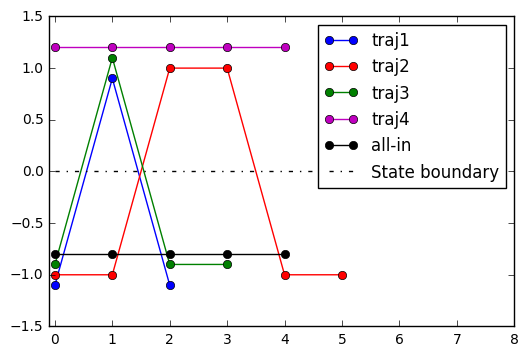

In [4]:
# plotting
plt.plot(xval(traj1), 'bo-', label='traj1')
plt.plot(xval(traj2), 'ro-', label='traj2')
plt.plot(xval(traj3), 'go-', label='traj3')
plt.plot(xval(traj4), 'mo-', label='traj4')

plt.plot(xval(all_in_traj), 'ko-', label='all-in')
plt.plot([0]*10, 'k-.', label='State boundary')
plt.ylim(-1.5, 1.5)
plt.xlim(-0.1, 8)
plt.legend();

## 1. Simple example

First let's consider an easy example. We'll define a single state. The trajectory we're interested in will begin in the state, then exit the state, then again return to the state. So we have the sequence `[AllInXEnsemble(state), AllOutXEnsemble(state), AllInXEnsemble(state)]`.

In [5]:
seq_ens_01 = paths.SequentialEnsemble([
    paths.AllInXEnsemble(state),
    paths.AllOutXEnsemble(state),
    paths.AllInXEnsemble(state)
])

In [6]:
seq_ens_01(all_in_traj)

False

In [7]:
seq_ens_01(traj1)

True

In [8]:
seq_ens_01(traj2)

True

## 2. Slightly less simple: cap ends with `LengthEnsemble(1)`

In [9]:
seq_ens_02 = paths.SequentialEnsemble([
    paths.AllInXEnsemble(state) & paths.LengthEnsemble(1),
    paths.AllOutXEnsemble(state),
    paths.AllInXEnsemble(state) & paths.LengthEnsemble(1)
])

In [10]:
seq_ens_02(all_in_traj)

False

In [11]:
seq_ens_02(traj1)

True

**You try it:** `traj2` satisfied seq_ens_01. Will it satisfy `seq_ens_02`? Try it yourself below.

In [ ]:
# write a line to check whether traj2 satisfies seq_ens_02 (but predict the result first!)

### Exercises

1. How would you implement a sequential ensemble which only has the length-1 cap at the beginning of the trajectory? Which of the given trajectories would satisfy that ensemble? 

2. How could you extend trajectories that do satisfy that ensemble so that they do not satisfy it?

3. Implement that ensemble. Test your predictions from question 1. Create trajectories and test your predictions from question 2.

## 3. Can-append in the sequential ensemble

The can-append function checks whether the given trajectory could be a subtrajectory of the given ensemble -- or, more correctly, it checks whether there is any possibility that after adding another frame, the resulting trajectory could be in the ensemble or could be a subtrajectory of the ensemble.

For the sequential ensemble, the logic behind this is quite complicated, and has a worst-case scaling of $O(n^2)$ in the length of the trajectory. However, for common sequential ensembles, the scaling is typically linear.

Let's consider the same trajectories and ensembles as before. Since the first sequential ensemble (`seq_ens_01`) does not have a limit on the the number of frames in either its beginning or ending ensemble, the `all_in_traj` could be a subtrajectory of it.

In [ ]:
seq_ens_01.can_append(all_in_traj)

**You try it:** Will `all_in_traj` also give `can_append` is true for `seq_ens_02`?

In [ ]:
# write a line to check whether can_append is true for all_in_traj in seq_ens_02

**Questions:** What's the shortest trajectory that would extend `all_in_traj` until `seq_ens_01.can_append` returned False? Would that trajectory satisfy `seq_ens_01`? Would any shorter subtrajectory of it satisfy `seq_ens_01`?

Note that a trajectory doesn't have to start in the first ensemble of the sequential ensemble in order to satisfy `can_append`. Any subtrajectory, beginning from any ensemble of the sequence, can satisfy `can_append`. (There is a separate method, `strict_can_append`, which requires that the trajectory begin in the initial state.)

Consider `traj4`, which has all its frames outside the state:

In [ ]:
seq_ens_01.can_append(traj4)

In [ ]:
seq_ens_02.can_append(traj4)

In addition, there is a function called `can_prepend`, which does the same as `can_append`, but in the reverse time direction.

### Exercises

1. Create a trajectory `traj` for which `seq_ens_02.can_append(traj) == True` and `seq_ens_02.can_prepend(traj) == False`.

## 4. Optional parts of the sequential ensemble

Up to here, this should be pretty straightforward: everything works exactly the way you'd expect it to work. But now we start to make things a little more complicated. In order to carefully define a generic version of a sequential ensemble, there are many cases where you might want to consider some sort of "optional" step in the sequence.

???


As a technical side-note, this is implemented by forming the union of the ensemble with a zero-length trajectory. This means that the zero-length trajectory must be excluded from any other ensemble used to build a sequential ensemble.

## 5. Using the `OptionalEnsemble` to generalize to the case of interstitials

One example where we have frequently used the `OptionalEnsemble` class is when we have interstitial space between the edge of the state and the innermost interface. In simple cases, the innermost interface of TIS is usually set to be exactly the boundary of the state. But this isn't a requirement of the method.

### Exercises

1. Consider an ensemble of trajectories which start ???. If the innermost interface is equivalent to the state border, then it can be defined as ???. How would you adjust this ensemble to account for the possibility of interstitial space between the state border and the innermost ensemble?

2. Which of the following trajectories should satisfy the ensemble with interstitials? Implement your proposal from question 1 and test it.
   1. traj1
   2. traj2

## 6. Sequential ensembles with non-disjoint adjacent ensembles

Up to this point, we've used sequential ensembles where the successive ensembles can't have overlapping frames. That is, you can't have a frame which is simultaneously inside and outside of the same state. You *can* describe sequential ensembles where such overlaps are allowed, but they become much more complicated and more subtle. In particular, you must pay special attention to whether you can sample the same ensemble using either the `can_append` or `can_prepend` functions.

In this, we've described some parts of the concepts of "consistent ensembles" and "efficient ensembles" from path ensemble theory. If you're working on problems where you are developing very complicated ensembles, we highly recommend that you become familiar with the mathematical structure described in path ensemble theory, because it will allow you to safely develop new path ensembles.

## 7. Sequential ensembles check status in the forward direction

Since it is possible for a trajectory to match a sequential ensemble when checked with the forward propagation, but not when checked with backward propagation (or vice-versa), it is important to know that, in practice, the code uses forward propagation to check. But we emphasize that an ensemble which doesn't give the same results in both directions is probably not suitable for most practical purposes.

Here is a small function `backward_check` which takes an ensemble and a trajectory and checks whether the trajectory satisfies the ensemble with checked with backward propagation. You will use it in the exercises below.

### Exercises

1. Given the ensemble ???, which of the following trajectories satisfy the ensemble based on forward propagation? Which satisfy backward propagation? Test your predictions
  1.  traj1
  2.  traj2

3. Redefine the ensemble so that all the trajectories in question 1 work for either forward or backward propagation.